<a href="https://colab.research.google.com/github/IvanSerem/ds2-proyecto-agricola/blob/main/DataScienceII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analizar eventos climáticos relevantes para el rendimiento agrícola en Argentina y su impacto potencial en los cultivos.

## 1️⃣ Antecedentes – Data Science I

En la primera etapa del proyecto (**Data Science I**) se desarrolló un modelo predictivo agrícola capaz de estimar el rendimiento de distintos cultivos a partir de variables del suelo y condiciones climáticas.

Se trabajó con más de **36.000 registros (2014–2023)**, construyendo un pipeline completo de Ciencia de Datos que culminó con un modelo **CatBoost Regressor** con las siguientes métricas:

- **R² ≈ 0.9787**
- **MAE ≈ 2.30**
- **RMSE ≈ 3.79**

Estos resultados demostraron una alta capacidad predictiva y estabilidad del modelo.

**Acceso al modelo**:
[Predictor Agrícola Inteligente](https://huggingface.co/spaces/IvanSerem/PREDICTOR-DE-RENDIMIENTO-AGRICOLA)


Sin embargo, el dataset original provenía de Kaggle y, aunque robusto, representaba una base estructurada y preprocesada.

---

## 2️⃣ Evolución del Proyecto

En Data Science I la pregunta central fue:

> ¿Es posible determinar, a partir de los valores del suelo y las condiciones climáticas, si una cosecha será fructífera?

En esta segunda etapa, la pregunta evoluciona hacia:

> ¿Cómo influyen los eventos climáticos reales ocurridos en Argentina sobre el rendimiento agrícola y qué patrones pueden identificarse a nivel provincial?

El objetivo ahora no es solamente predecir rendimiento, sino comprender el contexto climático real en el que esos rendimientos ocurren.

---

## 3️⃣ Construcción del Dataset Climático

Para esta etapa se incorporaron datos reales obtenidos mediante la API oficial **NASA POWER**, construyendo un dataset climático consolidado (2014–2023) que incluye:

- Temperatura media diaria (T2M)
- Temperatura máxima y mínima
- Precipitación diaria (PRECTOTCORR)
- Velocidad del viento (WS2M)
- Humedad relativa (RH2M)
- Ubicación geográfica por provincia

### Características del dataset final:

- **83.996 registros**
- **23 provincias**
- **10 años completos de datos diarios**

---

## 4️⃣ Alcance Analítico

Este nuevo dataset permite realizar:

- Análisis univariado
- Análisis bivariado
- Análisis multivariado
- Estudio de rachas de lluvia
- Análisis estacional
- Evaluación de correlaciones estructurales

---

## 5️⃣ Justificación del Estudio

El rendimiento agrícola no depende únicamente del suelo, sino también del comportamiento climático acumulado y de la ocurrencia de eventos extremos.

Factores como:

- Rachas prolongadas de lluvia
- Sequías estacionales
- Humedad persistente
- Vientos intensos
- Variaciones térmicas

Pueden alterar significativamente el resultado productivo, incluso cuando el suelo presenta condiciones óptimas.

Comprender la dinámica climática argentina permite:

- Interpretar mejor los resultados del modelo predictivo anterior.
- Detectar provincias con mayor riesgo climático.
- Identificar patrones estructurales entre regiones.
- Evaluar tendencias de disminución o aumento de precipitaciones.

---

## 🎯 Objetivo del Proyecto – Data Science II

Analizar eventos climáticos relevantes para el rendimiento agrícola en Argentina y su impacto potencial en los cultivos, utilizando datos reales provenientes de APIs oficiales.

---

## ❓ Preguntas Clave

- ¿Existen provincias con tendencias sostenidas de disminución de precipitaciones?
- ¿Cuál es la duración promedio de rachas de lluvia?
- ¿Mayor humedad implica necesariamente mayor precipitación?
- ¿Existe relación estructural entre temperatura y lluvia?
- ¿Qué provincias presentan mayor volatilidad climática?
- ¿Qué patrones estacionales predominan en cada región?


---

## 1.1 Importación de Librerías y Definición de Parámetros

### 🔹 Introducción

En esta sección importamos las librerías necesarias para la manipulación de datos, visualización y consumo de APIs.  
Además, definimos los parámetros temporales que delimitarán nuestro análisis, permitiendo mantener coherencia y control sobre el rango de información a consultar.


In [ ]:
# Importamos las librerías esenciales
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Configuramos un estilo visual para todos nuestros gráficos
sns.set_theme(style="whitegrid")

# Definimos los parámetros de la petición
url_base = "https://power.larc.nasa.gov/api/temporal/daily/point"
años_a_consultar = list(range(2014, 2024))


### 🔹 Conclusión

Como se observa, se establece un rango de años entre 2014 y 2023 inclusive, lo que nos permite analizar una década completa de datos climáticos.  

Este recorte temporal asegura consistencia histórica y facilita comparaciones interanuales en etapas posteriores del análisis.

---

## 1.2 Extracción de Datos en Lotes

### 🔹 Introducción

Para facilitar la manipulación y evitar errores en la consulta de datos, realizamos la extracción de información en lotes anuales.  

La solicitud se ejecuta iterando sobre los años definidos previamente y utilizando las coordenadas de latitud y longitud correspondientes a distintas provincias argentinas.  

Este enfoque permite mantener control sobre el volumen de datos descargados y reduce el riesgo de fallos en la conexión o limitaciones de la API.



In [ ]:
import pandas as pd
import requests
import time

# =========================
# Configuración base NASA POWER
# =========================
url_base = "https://power.larc.nasa.gov/api/temporal/daily/point"
años_a_consultar = list(range(2014, 2024))

# Provincias argentinas (capital provincial como punto representativo)
provincias = {
    "Buenos Aires": (-34.61, -58.38),
    "Catamarca": (-28.47, -65.78),
    "Chaco": (-27.45, -58.99),
    "Chubut": (-43.30, -65.10),
    "Córdoba": (-31.42, -64.18),
    "Corrientes": (-27.47, -58.83),
    "Entre Ríos": (-31.73, -60.53),
    "Formosa": (-26.18, -58.17),
    "Jujuy": (-24.18, -65.33),
    "La Pampa": (-36.62, -64.29),
    "La Rioja": (-29.41, -66.86),
    "Mendoza": (-32.89, -68.83),
    "Misiones": (-27.37, -55.90),
    "Neuquén": (-38.95, -68.06),
    "Río Negro": (-40.81, -63.00),
    "Salta": (-24.78, -65.41),
    "San Juan": (-31.53, -68.52),
    "San Luis": (-33.30, -66.34),
    "Santa Cruz": (-51.62, -69.22),
    "Santa Fe": (-31.63, -60.70),
    "Santiago del Estero": (-27.78, -64.27),
    "Tierra del Fuego": (-54.80, -68.30),
    "Tucumán": (-26.82, -65.22)
}

# Acá guardamos TODO (todas las provincias, todos los años)
lista_dataframes = []

print("--- Realizando la petición en lotes (por provincia y por año) con NASA POWER ---")

for provincia, (lat, lon) in provincias.items():
    print(f"\n📍 Provincia: {provincia} | lat={lat}, lon={lon}")

    for anio in años_a_consultar:
        print(f"  Obteniendo datos para el año {anio}...")

        params = {
            "latitude": lat,
            "longitude": lon,
            "start": f"{anio}0101",
            "end": f"{anio}1231",
            "parameters": "T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,WS2M,RH2M",
            "community": "AG",
            "format": "JSON"
        }

        try:
            response = requests.get(url_base, params=params, timeout=60)
            response.raise_for_status()

            payload = response.json()

            # NASA POWER no trae "data": trae "properties/parameter"
            data_params = payload["properties"]["parameter"]

            # data_params: {variable: {YYYYMMDD: valor}}
            df_anual = pd.DataFrame(data_params)

            # convertir índice YYYYMMDD a fecha
            df_anual["date"] = pd.to_datetime(df_anual.index, format="%Y%m%d")
            df_anual["anio"] = anio
            df_anual["provincia"] = provincia
            df_anual["lat"] = lat
            df_anual["lon"] = lon

            lista_dataframes.append(df_anual.reset_index(drop=True))
            print(f"    ✅ Datos {provincia} {anio}: {len(df_anual)} registros.")

            time.sleep(0.2)

        except requests.exceptions.RequestException as e:
            print(f"    ❌ Error en {provincia} {anio}: {e}")


--- Realizando la petición en lotes (por provincia y por año) con NASA POWER ---

📍 Provincia: Buenos Aires | lat=-34.61, lon=-58.38
  Obteniendo datos para el año 2014...
    ✅ Datos Buenos Aires 2014: 365 registros.
  Obteniendo datos para el año 2015...
    ✅ Datos Buenos Aires 2015: 365 registros.
  Obteniendo datos para el año 2016...
    ✅ Datos Buenos Aires 2016: 366 registros.
  Obteniendo datos para el año 2017...
    ✅ Datos Buenos Aires 2017: 365 registros.
  Obteniendo datos para el año 2018...
    ✅ Datos Buenos Aires 2018: 365 registros.
  Obteniendo datos para el año 2019...
    ✅ Datos Buenos Aires 2019: 365 registros.
  Obteniendo datos para el año 2020...
    ✅ Datos Buenos Aires 2020: 366 registros.
  Obteniendo datos para el año 2021...
    ✅ Datos Buenos Aires 2021: 365 registros.
  Obteniendo datos para el año 2022...
    ✅ Datos Buenos Aires 2022: 365 registros.
  Obteniendo datos para el año 2023...
    ✅ Datos Buenos Aires 2023: 365 registros.

📍 Provincia: Cat

### 🔹 Conclusión

La extracción segmentada por año y por ubicación geográfica garantiza mayor estabilidad en el proceso de adquisición de datos.  

Además, este método facilita futuras validaciones, reprocesamientos parciales y control de calidad en etapas posteriores del proyecto.API.

---

## 1.3 Inspección de los Resultados del Bucle

### 🔹 Introducción

Antes de consolidar todos los datos en un único DataFrame, es fundamental verificar qué información fue recolectada durante la ejecución del bucle.

La variable `lista_dataframes` debería contener un DataFrame por cada año consultado exitosamente.  
Por ello, realizamos una inspección inicial para validar:

- Cantidad de DataFrames recolectados.
- Estructura del primer DataFrame.
- Forma (filas y columnas).
- Primeras observaciones del conjunto de datos.

Esta etapa nos permite detectar posibles errores antes de avanzar a la concatenación final.



In [ ]:
# Verificamos cuántos DataFrames hemos recolectado
# Debería ser uno por cada año que no dio error.
print(f"Se han recolectado {len(lista_dataframes)} DataFrames en total.")

# Inspeccionemos el primer DataFrame de la lista para ver su estructura y contenido
# Este corresponde a los datos del primer año que consultamos (2020)
if lista_dataframes:
    print("\n--- Analizando el PRIMER DataFrame de la lista (datos del año 2020) ---")

    # Seleccionamos el primer elemento de la lista
    primer_df = lista_dataframes[0]

    # Mostramos su forma y sus primeras filas
    print(f"Forma del primer DataFrame: {primer_df.shape}")
    print("Primeras 3 filas:")
    display(primer_df.head(3))


Se han recolectado 230 DataFrames en total.

--- Analizando el PRIMER DataFrame de la lista (datos del año 2020) ---
Forma del primer DataFrame: (365, 11)
Primeras 3 filas:


,T2M,T2M_MAX,T2M_MIN,PRECTOTCORR,WS2M,RH2M,date,anio,provincia,lat,lon
0,27.94,30.52,25.09,23.96,2.83,65.29,2014-01-01,2014,Buenos Aires,-34.61,-58.38
1,24.30,25.51,22.09,14.94,6.22,71.09,2014-01-02,2014,Buenos Aires,-34.61,-58.38
2,21.41,23.97,18.59,0.00,5.18,54.43,2014-01-03,2014,Buenos Aires,-34.61,-58.38


### 🔹 Conclusión

Esta verificación preliminar nos permite asegurar que la extracción de datos fue exitosa y que cada año consultado generó un DataFrame con la estructura esperada.

Validar la cantidad de elementos y revisar la forma del primer DataFrame reduce el riesgo de errores posteriores en la etapa de concatenación y análisis exploratorio (EDA).

De esta manera, mantenemos control sobre la calidad y consistencia de los datos desde las primeras fases del proyecto.

---

## 1.4 Consolidación y Verificación

### 🔹 Introducción

Una vez completada la extracción en lotes, procedemos a consolidar todos los DataFrames almacenados en `lista_dataframes` en una única tabla maestra.

Para ello utilizamos `pd.concat()`, lo que nos permite unificar la información de todas las provincias y años en un solo DataFrame estructurado.

Posteriormente realizamos una verificación inicial para validar:

- Dimensión del dataset final
- Tipos de datos
- Cobertura temporal
- Cantidad de provincias incluidas

Este paso es fundamental para confirmar la integridad del conjunto de datos antes de avanzar hacia etapas de limpieza o análisis exploratorio.



In [ ]:
# 1.4. Consolidación y Verificación

# Verificamos que la lista no esté vacía antes de continuar
if lista_dataframes:
    # Unimos todos los DataFrames (todas las provincias y años)
    df_clima_crudo = pd.concat(lista_dataframes, ignore_index=True)

    print("\n--- ¡DataFrame Consolidado Creado Exitosamente! ---")
    print(f"Forma del DataFrame final: {df_clima_crudo.shape}")

    # Información general para un primer diagnóstico
    print("\n--- Información General ---")
    df_clima_crudo.info()

    # Verificación rápida de cobertura
    print("\n--- Verificaciones básicas ---")
    print("Provincias incluidas:", df_clima_crudo["provincia"].nunique())
    print("Años incluidos:", df_clima_crudo["anio"].unique())
    print("Rango de fechas:", df_clima_crudo["date"].min(), "→", df_clima_crudo["date"].max())
else:
    print("No se pudieron cargar los datos.")



--- ¡DataFrame Consolidado Creado Exitosamente! ---
Forma del DataFrame final: (83996, 11)

--- Información General ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83996 entries, 0 to 83995
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   T2M          83996 non-null  float64       
 1   T2M_MAX      83996 non-null  float64       
 2   T2M_MIN      83996 non-null  float64       
 3   PRECTOTCORR  83996 non-null  float64       
 4   WS2M         83996 non-null  float64       
 5   RH2M         83996 non-null  float64       
 6   date         83996 non-null  datetime64[ns]
 7   anio         83996 non-null  int64         
 8   provincia    83996 non-null  object        
 9   lat          83996 non-null  float64       
 10  lon          83996 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 7.0+ MB

--- Verificaciones básicas ---
Provincias incluidas

### 🔹 Conclusión

El proceso de consolidación generó un dataset con 83.996 registros y 11 variables, cubriendo 23 provincias argentinas y un período completo entre 2014 y 2023.

La verificación confirma que:

- No existen valores nulos iniciales.
- Las variables climáticas fueron correctamente tipadas como numéricas.
- La variable de fecha fue reconocida como tipo `datetime`.
- La cobertura temporal es consistente y continua.

Con esta estructura consolidada, el dataset se encuentra listo para avanzar hacia la fase de limpieza optimizada (Data Wrangling) y posterior Análisis Exploratorio de Datos (EDA).

---

# Módulo 2: Data Wrangling del Dataset Climático

El dataset climático proveniente de la API NASA POWER presenta una estructura tabular organizada, sin datos anidados ni metadata técnica redundante.

Sin embargo, para su correcta utilización en análisis exploratorio y modelado predictivo, resulta necesario optimizar su estructura, estandarizar su semántica y enriquecer sus variables.

En este módulo se realiza el proceso de Data Wrangling, orientado a transformar el dataset crudo en una base analítica consistente y preparada para la toma de decisiones.

---

## Acciones realizadas

### 🔹 1. Selección de Variables (Feature Selection)

Se conservaron únicamente las variables climáticas relevantes para el análisis agrícola, eliminando columnas que no aportaban valor directo al objetivo del proyecto.

Esta reducción de dimensionalidad mejora la eficiencia computacional y simplifica el análisis posterior.

---

### 🔹 2. Estandarización y Renombrado de Columnas

Las variables originales fueron renombradas bajo una nomenclatura clara y coherente en español, facilitando la interpretación y comunicación del análisis.

Este ajuste semántico mejora la legibilidad del código y reduce la ambigüedad conceptual.

---

### 🔹 3. Transformación de Tipos de Datos

Se verificaron y ajustaron los tipos de datos, especialmente la variable temporal, asegurando su correcta conversión al formato `datetime`.

Una tipificación adecuada permite realizar análisis temporales, agregaciones y segmentaciones con precisión.

---

### 🔹 4. Creación de Nuevas Variables (Feature Engineering)

Se generaron variables derivadas a partir de las originales, incluyendo conversiones de unidades y componentes temporales.

El objetivo fue enriquecer el dataset para capturar patrones climáticos relevantes que puedan influir en el rendimiento agrícola y en futuros modelos predictivos.

## 2.1 Exploración Inicial de Columnas

### 🔹 Introducción

Antes de realizar cualquier proceso de selección o transformación, es importante inspeccionar la estructura del dataset consolidado.

En este caso, listamos todas las columnas presentes en `df_clima_crudo` para:

- Identificar las variables disponibles.
- Verificar consistencia en los nombres.
- Detectar posibles campos innecesarios.
- Preparar la etapa de selección y renombrado.

Esta inspección nos permite entender con precisión la composición del dataset antes de modificarlo.



In [ ]:
for columna in df_clima_crudo.columns:
  print(columna)

T2M
T2M_MAX
T2M_MIN
PRECTOTCORR
WS2M
RH2M
date
anio
provincia
lat
lon


### 🔹 Conclusión

El dataset contiene variables climáticas principales (temperatura, precipitación, viento, humedad), variables temporales y variables geográficas.

Esta estructura confirma que contamos con información suficiente para realizar análisis temporal, espacial y climático, lo que permitirá avanzar hacia una selección de variables estratégicamente orientada al objetivo agrícola del proyecto.

---

## 2.2 Selección y Renombrado de Variables Climáticas

### 🔹 Introducción

Las variables originales del dataset proveniente de NASA POWER se encuentran expresadas en nomenclatura científica y terminología técnica en inglés.

Si bien son correctas desde el punto de vista académico, para facilitar la interpretación, el análisis y la comunicación del proyecto, se procede a:

- Seleccionar únicamente las columnas relevantes.
- Renombrar las variables con una semántica clara en español.
- Mantener coherencia conceptual para etapas posteriores de modelado.

Este proceso mejora la legibilidad del código y fortalece la calidad analítica del dataset.



In [ ]:
# ============================================
# MÓDULO 2 – DATA WRANGLING
# Dataset Climático – NASA POWER
# ============================================

import pandas as pd

# ------------------------------------------------
# 1. PARTIMOS DEL DATAFRAME CRUDO
# ------------------------------------------------
# Se asume que df_clima_crudo ya fue creado en el Módulo 1
# (adquisición y consolidación de datos)

print("Forma del DataFrame crudo:")
print(df_clima_crudo.shape)

# ------------------------------------------------
# 2. SELECCIÓN DE COLUMNAS RELEVANTES
# ------------------------------------------------
columnas_relevantes = [
    "T2M",
    "T2M_MAX",
    "T2M_MIN",
    "PRECTOTCORR",
    "WS2M",
    "RH2M",
    "date",
    "anio",
    "provincia",
    "lat",
    "lon"
]

df_clima_limpio = df_clima_crudo[columnas_relevantes].copy()

print("\nColumnas seleccionadas:")
print(df_clima_limpio.columns)

# ------------------------------------------------
# 3. RENOMBRADO DE COLUMNAS (CLARIDAD SEMÁNTICA)
# ------------------------------------------------
df_clima_limpio = df_clima_limpio.rename(columns={
    "T2M": "temp_media",
    "T2M_MAX": "temp_max",
    "T2M_MIN": "temp_min",
    "PRECTOTCORR": "precipitacion",
    "WS2M": "vel_viento",
    "RH2M": "humedad",
    "date": "fecha",
    "anio": "anio",
    "provincia": "provincia",
    "lat": "latitud",
    "lon": "longitud"
})

# ------------------------------------------------
# 4. VERIFICACIÓN GENERAL DEL DATASET
# ------------------------------------------------
print("\n--- Información del DataFrame Limpio ---")
df_clima_limpio.info()

print("\n--- Primeras filas del DataFrame Limpio ---")
df_clima_limpio.head()


Forma del DataFrame crudo:
(83996, 11)

Columnas seleccionadas:
Index(['T2M', 'T2M_MAX', 'T2M_MIN', 'PRECTOTCORR', 'WS2M', 'RH2M', 'date',
       'anio', 'provincia', 'lat', 'lon'],
      dtype='object')

--- Información del DataFrame Limpio ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83996 entries, 0 to 83995
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   temp_media     83996 non-null  float64       
 1   temp_max       83996 non-null  float64       
 2   temp_min       83996 non-null  float64       
 3   precipitacion  83996 non-null  float64       
 4   vel_viento     83996 non-null  float64       
 5   humedad        83996 non-null  float64       
 6   fecha          83996 non-null  datetime64[ns]
 7   anio           83996 non-null  int64         
 8   provincia      83996 non-null  object        
 9   latitud        83996 non-null  float64       
 10  longitud       83996 non-nul

,temp_media,temp_max,temp_min,precipitacion,vel_viento,humedad,fecha,anio,provincia,latitud,longitud
0,27.94,30.52,25.09,23.96,2.83,65.29,2014-01-01,2014,Buenos Aires,-34.61,-58.38
1,24.30,25.51,22.09,14.94,6.22,71.09,2014-01-02,2014,Buenos Aires,-34.61,-58.38
2,21.41,23.97,18.59,0.00,5.18,54.43,2014-01-03,2014,Buenos Aires,-34.61,-58.38
3,24.35,28.11,20.04,0.00,5.16,47.29,2014-01-04,2014,Buenos Aires,-34.61,-58.38
4,26.02,30.74,20.78,0.00,3.16,61.97,2014-01-05,2014,Buenos Aires,-34.61,-58.38


### 🔹 Conclusión

El dataset fue reducido a las variables climáticas esenciales y renombrado bajo una nomenclatura clara y coherente en español.

Este ajuste:

- Mejora la interpretación de resultados.
- Facilita la comunicación del análisis.
- Reduce fricción cognitiva en etapas de EDA y modelado.
- Prepara el dataset para futuras transformaciones y generación de variables derivadas.

Con esta estructura semántica optimizada, el DataFrame se encuentra listo para continuar con la fase de Feature Engineering y análisis exploratorio.


## 2.3 Conversión de Velocidad del Viento a km/h

### 🔹 Introducción

La variable original `vel_viento` se encuentra expresada en metros por segundo (m/s), unidad estándar utilizada en datos meteorológicos internacionales.

Sin embargo, para facilitar la interpretación práctica y hacer los valores más intuitivos dentro del contexto local, se decide convertir esta métrica a kilómetros por hora (km/h).

La conversión se realiza multiplicando por 3.6, dado que:

1 m/s = 3.6 km/h

Además, se redondea el resultado a un decimal para mejorar la legibilidad sin perder precisión relevante.

In [ ]:
df_clima_limpio["vel_viento_kmh"] = (
    df_clima_limpio["vel_viento"] * 3.6
).round(1)


In [ ]:
df_clima_limpio.head()


,temp_media,temp_max,temp_min,precipitacion,vel_viento,humedad,fecha,anio,provincia,latitud,longitud,vel_viento_kmh
0,27.94,30.52,25.09,23.96,2.83,65.29,2014-01-01,2014,Buenos Aires,-34.61,-58.38,10.2
1,24.30,25.51,22.09,14.94,6.22,71.09,2014-01-02,2014,Buenos Aires,-34.61,-58.38,22.4
2,21.41,23.97,18.59,0.00,5.18,54.43,2014-01-03,2014,Buenos Aires,-34.61,-58.38,18.6
3,24.35,28.11,20.04,0.00,5.16,47.29,2014-01-04,2014,Buenos Aires,-34.61,-58.38,18.6
4,26.02,30.74,20.78,0.00,3.16,61.97,2014-01-05,2014,Buenos Aires,-34.61,-58.38,11.4


La nueva variable `vel_viento_kmh` permite una lectura más clara y alineada con el sistema de medición comúnmente utilizado en Argentina.

Este tipo de transformación mejora la interpretabilidad del dataset sin alterar la información original, y resulta especialmente útil en contextos productivos donde la velocidad del viento impacta directamente en actividades agrícolas.

Con esta variable derivada, el dataset gana claridad operativa y queda mejor preparado para análisis descriptivos y modelos predictivos.

---


## Conclusión del Módulo

Este proceso de Data Wrangling convierte un conjunto de datos crudo en una base estructurada, optimizada y analíticamente robusta.

Más allá de la limpieza técnica, este módulo establece los fundamentos para un análisis exploratorio sólido y para el desarrollo de modelos predictivos confiables.


📊 Módulo 3: EDA y Data Storytelling
Con nuestro dataset limpio y enriquecido, es hora de hacerle preguntas y usar visualizaciones para responderlas y contar una historia.

Pregunta 1: ¿Cómo se distribuye la magnitud de los terremotos significativos?

## 3.1 Identificación de las Provincias con Mayor Temperatura Media

### 🔹 Introducción

Como parte del Análisis Exploratorio de Datos (EDA), se analiza la temperatura media anual (`T2M`) por provincia para identificar cuáles presentan los valores promedio más elevados durante el período 2014–2023.

Este análisis permite:

- Detectar patrones climáticos regionales.
- Identificar zonas con mayor acumulación térmica.
- Comprender posibles impactos en la producción agrícola.

Para ello, se calcula la media de temperatura por provincia y se ordenan los resultados de mayor a menor.


/tmp/ipython-input-3982519842.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


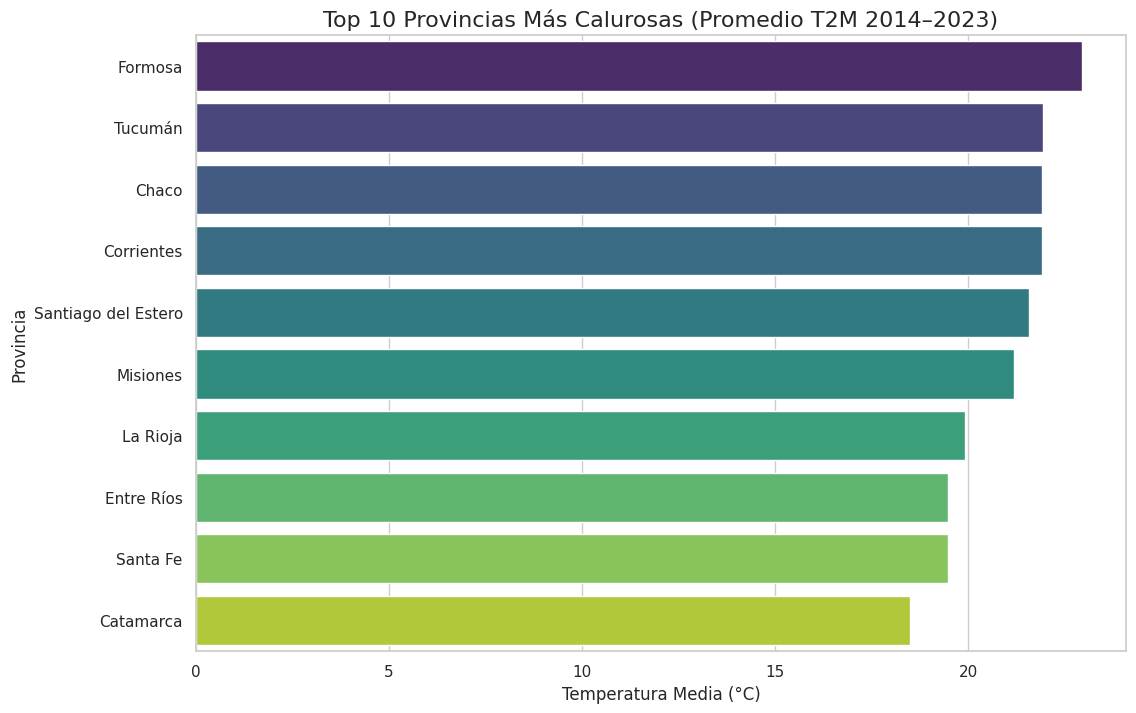

,T2M
provincia,
Formosa,22.944137
Tucumán,21.949762
Chaco,21.917823
Corrientes,21.917823
Santiago del Estero,21.569480
Misiones,21.179644
La Rioja,19.916073
Entre Ríos,19.488267
Santa Fe,19.488267


In [ ]:
# ==============================
# TOP 10 PROVINCIAS MÁS CALUROSAS
# ==============================

# 1️⃣ Calculamos la temperatura promedio por provincia
top_10_calor = (
    df_clima_crudo
    .groupby("provincia")["T2M"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# 2️⃣ Visualización
plt.figure(figsize=(12, 8))

sns.barplot(
    y=top_10_calor.index,
    x=top_10_calor.values,
    palette="viridis"
)

plt.title("Top 10 Provincias Más Calurosas (Promedio T2M 2014–2023)", fontsize=16)
plt.xlabel("Temperatura Media (°C)", fontsize=12)
plt.ylabel("Provincia", fontsize=12)

plt.show()

# 3️⃣ Mostrar valores numéricos
display(top_10_calor)


### 🔹 Conclusión y Observación de los Datos

El análisis revela que las provincias del noreste argentino (Formosa, Chaco, Corrientes y Misiones) lideran el ranking de temperaturas medias más elevadas.

También se destacan provincias del noroeste como Tucumán y Santiago del Estero, lo que confirma la influencia de factores climáticos regionales característicos de zonas subtropicales y semiáridas.

La diferencia térmica entre la primera y la décima provincia no es extremadamente amplia, lo que indica que gran parte del norte argentino mantiene promedios térmicos elevados de manera sostenida.

Desde una perspectiva agrícola, estas condiciones pueden:

- Favorecer cultivos que requieren alta acumulación térmica.
- Incrementar el riesgo de estrés hídrico si no se acompaña con niveles adecuados de precipitación.
- Impactar en la planificación de calendarios productivos.

Este resultado confirma la coherencia climática esperada y valida la consistencia del dataset consolidado.

---


## 3.2 Identificación de las Provincias con Mayor Precipitación Acumulada

### 🔹 Introducción

En esta sección del Análisis Exploratorio de Datos (EDA), se estudia la precipitación total acumulada por provincia durante el período 2014–2023.

El objetivo es identificar cuáles regiones presentan mayor disponibilidad hídrica a lo largo de la década analizada.

A diferencia del análisis anterior de temperatura media, en este caso se realiza una agregación por suma, ya que interesa conocer el volumen total de lluvia acumulado en milímetros.

Este análisis es clave para comprender:

- La distribución regional de recursos hídricos.
- El potencial agrícola por disponibilidad de agua.
- La exposición a eventos de exceso hídrico.


/tmp/ipython-input-1846339240.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


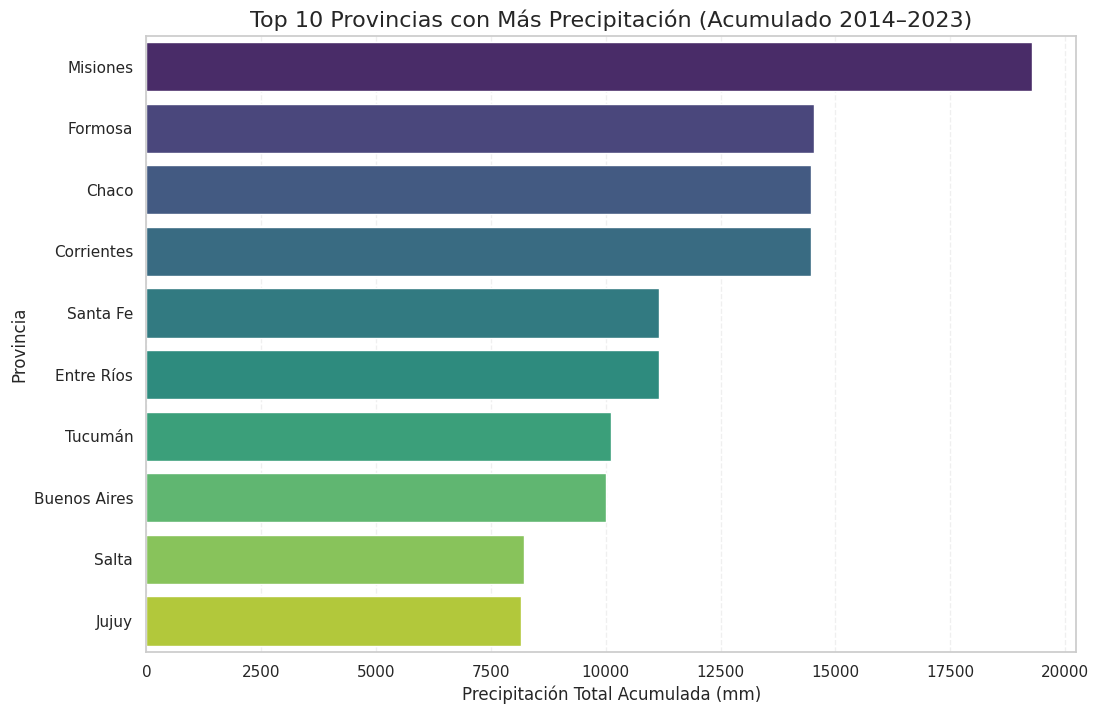

,precipitacion_total_mm
provincia,
Misiones,19279.11
Formosa,14529.04
Chaco,14469.56
Corrientes,14469.56
Santa Fe,11164.28
Entre Ríos,11164.28
Tucumán,10124.12
Buenos Aires,10003.27
Salta,8216.83


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# TOP 10 PROVINCIAS MÁS LLUVIOSAS
# (PRECIPITACIÓN TOTAL ACUMULADA)
# ==============================

# 1) Agregación: suma de precipitación por provincia
top_10_lluvia = (
    df_clima_crudo
    .groupby("provincia")["PRECTOTCORR"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# 2) Plot
plt.figure(figsize=(12, 8))

sns.barplot(
    y=top_10_lluvia.index,
    x=top_10_lluvia.values,
    palette="viridis"
)

plt.title("Top 10 Provincias con Más Precipitación (Acumulado 2014–2023)", fontsize=16)
plt.xlabel("Precipitación Total Acumulada (mm)", fontsize=12)
plt.ylabel("Provincia", fontsize=12)

# 3) Formato de ticks para que se lea mejor
plt.ticklabel_format(style='plain', axis='x')  # evita notación científica
plt.grid(True, axis="x", linestyle="--", alpha=0.3)

plt.show()

# 4) Mostrar valores numéricos
display(top_10_lluvia.to_frame(name="precipitacion_total_mm"))


---

### 🔹 Conclusión y Observación de los Datos

El análisis muestra que la provincia de Misiones lidera ampliamente el ranking de precipitación acumulada, lo cual es consistente con su clima subtropical húmedo.

Las provincias del noreste argentino (NEA) —Misiones, Formosa, Chaco y Corrientes— concentran los mayores volúmenes de lluvia, confirmando una marcada diferencia respecto a regiones más áridas del país.

También se observa la presencia de provincias de la región pampeana como Santa Fe y Buenos Aires, lo que refuerza su relevancia productiva en términos agrícolas.

Desde una perspectiva agroclimática, estas provincias presentan:

- Alta disponibilidad hídrica sostenida.
- Potencial favorable para cultivos extensivos.
- Mayor riesgo de excesos hídricos y eventos extremos en determinados períodos.

El patrón observado resulta coherente con la distribución climática argentina y valida la consistencia del dataset analizado.


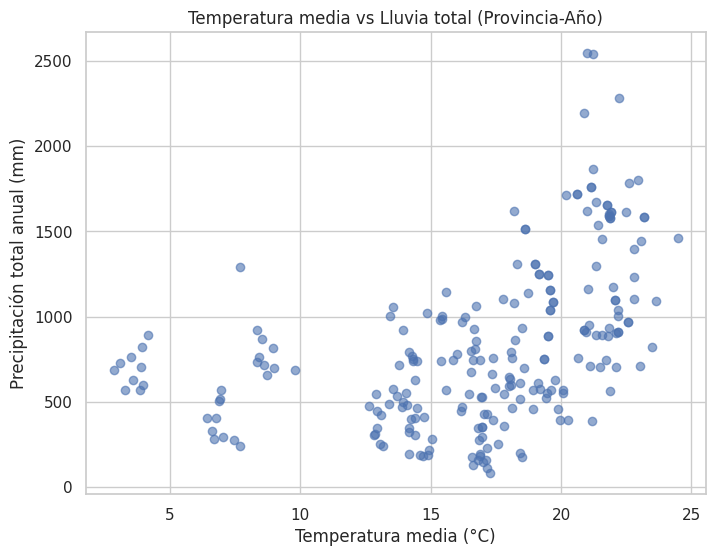

In [ ]:
import matplotlib.pyplot as plt

# 1️⃣ Agrupamos por provincia y año
df_simple = (
    df_clima_crudo
    .groupby(["provincia", "anio"], as_index=False)
    .agg(
        temp_media=("T2M", "mean"),
        lluvia_total=("PRECTOTCORR", "sum")
    )
)

# 2️⃣ Creamos gráfico simple
plt.figure(figsize=(8,6))
plt.scatter(df_simple["temp_media"], df_simple["lluvia_total"], alpha=0.6)

plt.title("Temperatura media vs Lluvia total (Provincia-Año)")
plt.xlabel("Temperatura media (°C)")
plt.ylabel("Precipitación total anual (mm)")

plt.show()


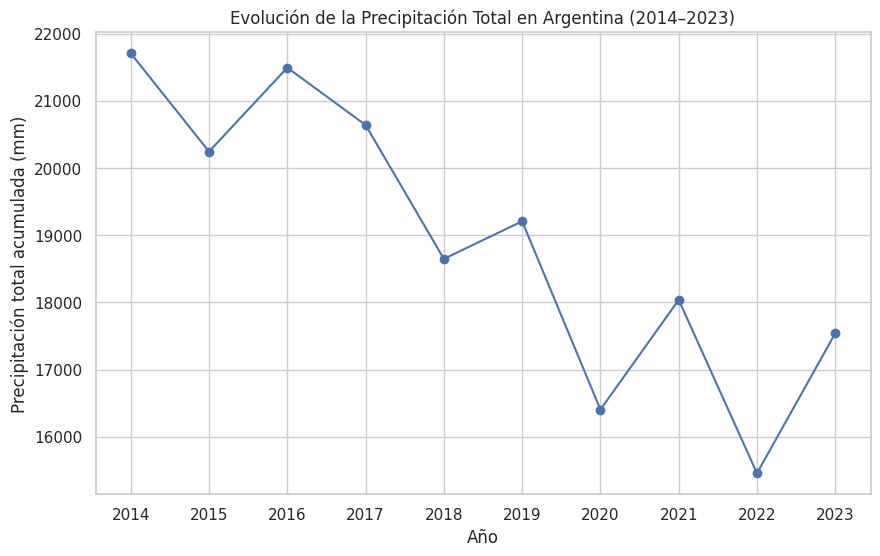

,anio,lluvia_total
0,2014,21708.22
1,2015,20245.08
2,2016,21493.70
3,2017,20640.80
4,2018,18648.44
5,2019,19207.93
6,2020,16405.63
7,2021,18038.44
8,2022,15458.20
9,2023,17541.58


In [ ]:
import matplotlib.pyplot as plt

# 1️⃣ Agrupamos por año
lluvia_anual = (
    df_clima_crudo
    .groupby("anio", as_index=False)
    .agg(lluvia_total=("PRECTOTCORR", "sum"))
)

# 2️⃣ Creamos gráfico de línea
plt.figure(figsize=(10,6))
plt.plot(lluvia_anual["anio"], lluvia_anual["lluvia_total"], marker="o")

plt.title("Evolución de la Precipitación Total en Argentina (2014–2023)")
plt.xlabel("Año")
plt.ylabel("Precipitación total acumulada (mm)")
plt.xticks(lluvia_anual["anio"])

plt.show()

# Mostrar valores numéricos
display(lluvia_anual)


## 3.3 Relación entre Humedad Relativa y Precipitación Anual

### 🔹 Introducción

En esta sección se analiza la relación entre la humedad relativa media anual y la precipitación total acumulada por provincia y año.

El objetivo es evaluar si existe una asociación estadística entre:

- La humedad promedio del ambiente.
- El volumen total de lluvia acumulada en el año.

Para ello:

1. Se agrupan los datos por provincia y año.
2. Se calcula la humedad media anual.
3. Se calcula la precipitación total anual.
4. Se visualiza la relación mediante un gráfico de dispersión.
5. Se calcula la correlación utilizando los métodos de Pearson y Spearman.

Este análisis permite detectar patrones climáticos estructurales y validar coherencia interna del dataset.

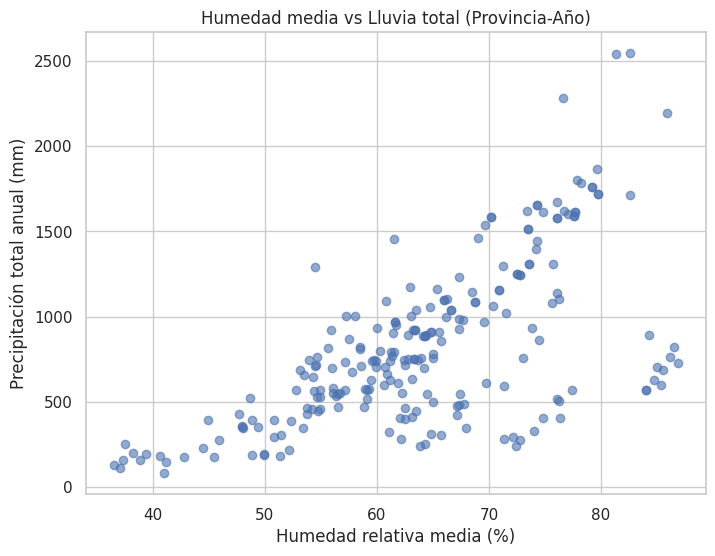

Correlación Pearson: 0.644
Correlación Spearman: 0.634


In [ ]:
import matplotlib.pyplot as plt

# 1️⃣ Agrupamos por provincia y año
df_humedad = (
    df_clima_crudo
    .groupby(["provincia", "anio"], as_index=False)
    .agg(
        humedad_media=("RH2M", "mean"),
        lluvia_total=("PRECTOTCORR", "sum"),
        lluvia_media=("PRECTOTCORR", "mean")
    )
)

# 2️⃣ Scatter simple
plt.figure(figsize=(8,6))
plt.scatter(df_humedad["humedad_media"], df_humedad["lluvia_total"], alpha=0.6)

plt.title("Humedad media vs Lluvia total (Provincia-Año)")
plt.xlabel("Humedad relativa media (%)")
plt.ylabel("Precipitación total anual (mm)")

plt.show()

# 3️⃣ Correlación
corr_pearson = df_humedad["humedad_media"].corr(df_humedad["lluvia_total"])
corr_spearman = df_humedad["humedad_media"].corr(df_humedad["lluvia_total"], method="spearman")

print(f"Correlación Pearson: {corr_pearson:.3f}")
print(f"Correlación Spearman: {corr_spearman:.3f}")


### 🔹 Conclusión y Observación de los Datos

El gráfico de dispersión muestra una tendencia positiva clara: a medida que aumenta la humedad relativa media anual, también tiende a incrementarse la precipitación total acumulada.

Los coeficientes obtenidos:

- **Correlación de Pearson ≈ 0.64**
- **Correlación de Spearman ≈ 0.63**

Indican una correlación positiva moderada-alta entre ambas variables.

Esto sugiere que:

- Provincias más húmedas suelen registrar mayores volúmenes de lluvia.
- Existe coherencia física en los datos (consistencia climatológica).
- La humedad puede funcionar como variable explicativa relevante en futuros modelos predictivos.

Desde una perspectiva agroclimática, esta relación es esperable: regiones con mayor disponibilidad hídrica suelen presentar mayores niveles de humedad ambiental sostenida.

---

## 3.4 Distribución de la Precipitación Diaria

### 🔹 Introducción

En esta sección se analiza la distribución de la precipitación diaria durante el período 2014–2023.

A diferencia de los análisis anteriores, que se centraron en valores agregados (medias o acumulados), aquí se estudia la frecuencia con la que ocurren distintos niveles de lluvia diaria.

El objetivo es comprender:

- Cómo se distribuyen los eventos de lluvia.
- Si predominan días secos o lluvias intensas.
- La presencia de valores extremos.

Para ello, se construye un histograma utilizando la variable `PRECTOTCORR`.


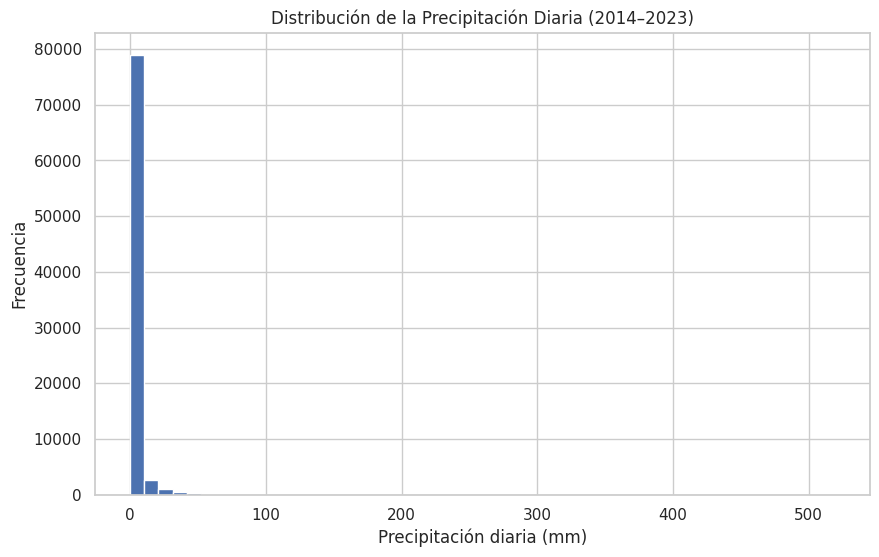

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# HISTOGRAMA DE PRECIPITACIÓN DIARIA
# ==========================================

plt.figure(figsize=(10,6))

plt.hist(df_clima_crudo["PRECTOTCORR"], bins=50)

plt.title("Distribución de la Precipitación Diaria (2014–2023)")
plt.xlabel("Precipitación diaria (mm)")
plt.ylabel("Frecuencia")

plt.show()


## 3.5 Concentración de la Precipitación: ¿Llueve Poco y Fuerte?

### 🔹 Introducción

Luego de analizar la distribución de la precipitación diaria, se busca responder una pregunta clave:

¿La lluvia está distribuida de manera uniforme o se concentra en pocos eventos intensos?

Para ello, se calculan:

- El porcentaje de días sin lluvia.
- El porcentaje del volumen total anual que cae en días con precipitaciones intensas (>20 mm).

Este análisis permite comprender la estructura real del régimen hídrico.


In [ ]:
dias_totales = len(df_clima_crudo)
dias_sin_lluvia = (df_clima_crudo["PRECTOTCORR"] == 0).sum()

print("Días totales:", dias_totales)
print("Días sin lluvia:", dias_sin_lluvia)
print("Porcentaje de días sin lluvia:",
      round(dias_sin_lluvia / dias_totales * 100, 2), "%")


Días totales: 83996
Días sin lluvia: 42585
Porcentaje de días sin lluvia: 50.7 %


In [ ]:
lluvia_total = df_clima_crudo["PRECTOTCORR"].sum()

dias_intensos = df_clima_crudo[df_clima_crudo["PRECTOTCORR"] > 20]

lluvia_intensa_total = dias_intensos["PRECTOTCORR"].sum()

print("Lluvia total acumulada:", round(lluvia_total, 2), "mm")
print("Lluvia en días intensos (>20mm):", round(lluvia_intensa_total, 2), "mm")
print("Porcentaje del agua que cayó en días intensos:",
      round(lluvia_intensa_total / lluvia_total * 100, 2), "%")


Lluvia total acumulada: 189388.02 mm
Lluvia en días intensos (>20mm): 95260.16 mm
Porcentaje del agua que cayó en días intensos: 50.3 %


### 🔹 Resultados Obtenidos

- **Días totales analizados:** 83.996  
- **Días sin lluvia:** 42.585  
- **Porcentaje de días sin lluvia:** 50,7 %

- **Lluvia total acumulada:** 189.388 mm  
- **Lluvia en días intensos (>20 mm):** 95.260 mm  
- **Porcentaje del agua concentrada en días intensos:** 50,3 %


### 🔹 Conclusión y Observación de los Datos

Los resultados muestran un patrón climático altamente concentrado:

- Más del 50 % de los días no registran lluvia.  
- Sin embargo, aproximadamente el 50 % del volumen total de agua cae en días con precipitaciones intensas (>20 mm).

Esto indica que el régimen hídrico no es uniforme, sino que se caracteriza por:

- Alta frecuencia de días secos.  
- Eventos de lluvia concentrados y de alta intensidad.

Desde una perspectiva agroclimática, este patrón puede implicar:

- Mayor riesgo de estrés hídrico entre eventos.  
- Dependencia de lluvias intensas para completar el acumulado anual.  
- Posible aumento del riesgo de erosión o anegamiento en determinados períodos.

---

## 3.6 Provincias con Mayor Humedad Relativa Promedio

### 🔹 Introducción

En esta sección se analiza la humedad relativa media anual por provincia durante el período 2014–2023.

La humedad relativa es una variable clave en climatología, ya que influye en:

- La sensación térmica.
- La evaporación del agua.
- El desarrollo de cultivos.
- La proliferación de enfermedades fúngicas.

A diferencia de la precipitación, la humedad relativa no mide directamente la cantidad de lluvia, sino la proporción de vapor de agua presente en el aire en relación con su capacidad máxima.

El objetivo es identificar qué provincias presentan los niveles promedio más elevados de humedad ambiental.

Top 10 Provincias con Mayor Humedad Promedio (2014-2023):


,RH2M
provincia,
Tierra del Fuego,85.269302
Misiones,77.901386
Santa Cruz,74.390586
Buenos Aires,74.286136
Chaco,72.715775
Corrientes,72.715775
Formosa,71.983686
Santa Fe,68.959608
Entre Ríos,68.959608


/tmp/ipython-input-1366845533.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


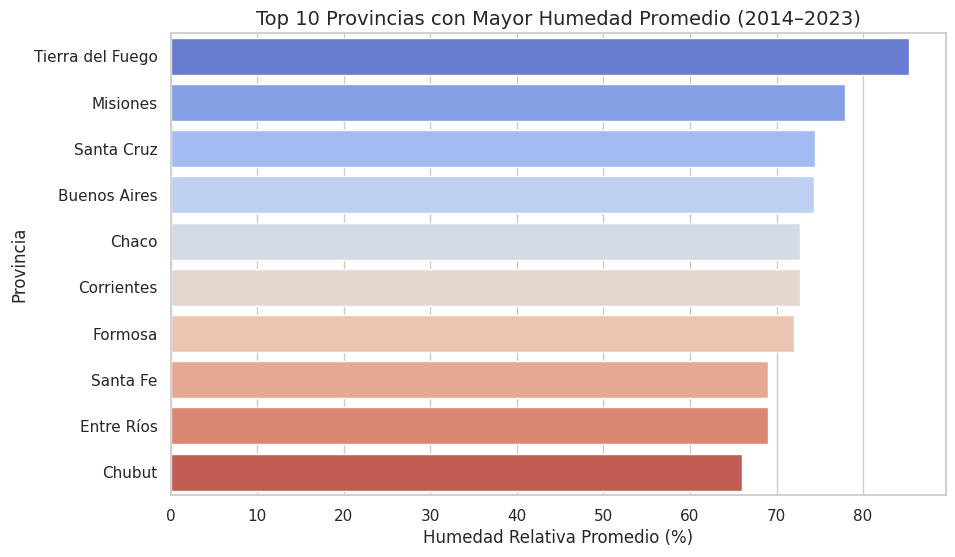

In [ ]:
# =========================================
# TOP 10 PROVINCIAS CON MAYOR HUMEDAD
# =========================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Promedio de humedad por provincia
humedad_por_provincia = (
    df_clima_crudo
    .groupby("provincia")["RH2M"]
    .mean()
    .sort_values(ascending=False)
)

# 2️⃣ Top 10
top_10_humedad = humedad_por_provincia.head(10)

print("Top 10 Provincias con Mayor Humedad Promedio (2014-2023):")
display(top_10_humedad)

# 3️⃣ Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_humedad.values,
    y=top_10_humedad.index,
    palette="coolwarm"
)

plt.title("Top 10 Provincias con Mayor Humedad Promedio (2014–2023)", fontsize=14)
plt.xlabel("Humedad Relativa Promedio (%)")
plt.ylabel("Provincia")
plt.show()


### 🔹 Conclusión y Observación de los Datos

El análisis muestra que **Tierra del Fuego** lidera el ranking de humedad relativa promedio, seguida por **Misiones** y provincias patagónicas como **Santa Cruz** y **Chubut**.

Se observan dos patrones interesantes:

- Provincias del noreste argentino (NEA), como **Misiones**, **Chaco** y **Corrientes**, presentan alta humedad asociada a climas subtropicales.
- Provincias del sur del país, como **Tierra del Fuego** y **Santa Cruz**, muestran alta humedad relativa aunque no necesariamente registren los mayores niveles de precipitación.

Esto confirma que la humedad relativa no depende únicamente de la cantidad de lluvia, sino también de factores como:

- Temperatura
- Latitud
- Cercanía al mar

Desde una perspectiva agroclimática, altos niveles de humedad pueden:

- Favorecer determinados cultivos.
- Aumentar el riesgo de enfermedades fúngicas.
- Influir en la planificación de calendarios productivos.

---

¿Qué provincias tienen más eventos (rachas) de lluvia a lo largo del período 2014–2023?

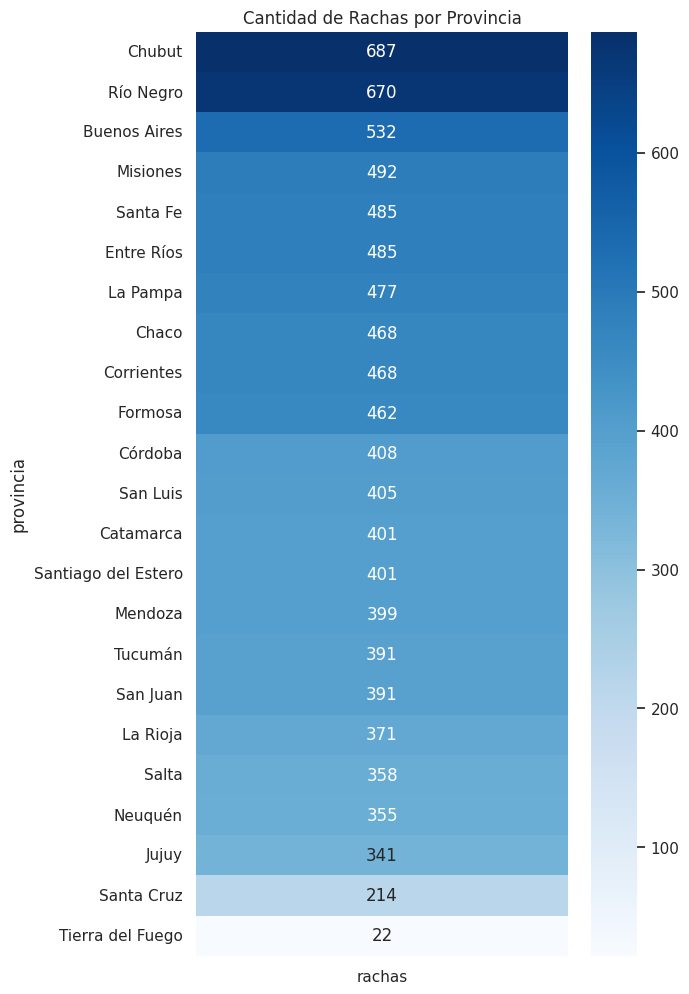

In [ ]:
import seaborn as sns

df_heat = rachas_por_provincia.reset_index()
df_heat.columns = ["provincia", "rachas"]

plt.figure(figsize=(6,12))
sns.heatmap(df_heat.set_index("provincia"), cmap="Blues", annot=True, fmt="d")

plt.title("Cantidad de Rachas por Provincia")
plt.show()


### 🔹 Interpretación de las Rachas de Lluvia: Enfoque Productivo

El análisis de rachas permite comprender no solo cuánto llueve, sino cómo se distribuye la lluvia en el tiempo.

En el caso de Chubut, se registraron 687 rachas de lluvia durante el período 2014–2023. Esto equivale aproximadamente a 69 rachas por año, es decir, en promedio, el inicio de una secuencia de lluvia cada 5 a 6 días.

Sin embargo, es importante aclarar que una racha no representa un único día de lluvia, sino el comienzo de una secuencia consecutiva de días con precipitación.

Desde una perspectiva productiva, este dato sugiere que:

- La lluvia puede ser relativamente frecuente.
- Los eventos podrían estar fragmentados en secuencias cortas.
- La disponibilidad hídrica dependerá no solo de la frecuencia, sino también de la duración e intensidad de cada racha.

En términos agrícolas, comprender la estructura temporal de la lluvia es más relevante que observar únicamente el acumulado anual, ya que impacta directamente en la infiltración del suelo, la retención de humedad y la planificación del riego.

---

## 3.8 Índice de Riesgo de Evaporación: Interpretación Agroclimática

### 🔹 Introducción

Luego de analizar la precipitación, la humedad y la temperatura por separado, se construye un índice simple de riesgo evaporativo para evaluar la posible pérdida de agua desde el suelo hacia la atmósfera.

El índice se define como:

Índice de evaporación = (Temperatura media × Velocidad del viento) / Humedad relativa

Este indicador no mide evaporación real, sino un potencial relativo de pérdida hídrica, basado en tres factores clave:

- Mayor temperatura → más energía disponible para evaporar.
- Mayor viento → mayor transporte del vapor de agua.
- Menor humedad relativa → mayor capacidad del aire para absorber agua.

El objetivo es comparar provincias en términos de presión climática sobre la humedad del suelo.


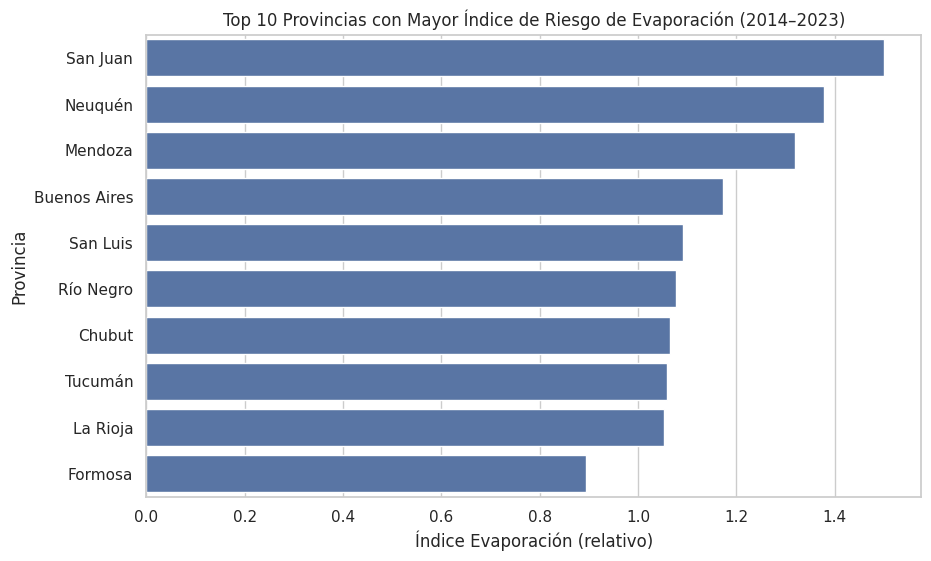

,indice_evaporacion
provincia,
San Juan,1.500913
Neuquén,1.378648
Mendoza,1.318779
Buenos Aires,1.173201
San Luis,1.092166
Río Negro,1.077003
Chubut,1.064257
Tucumán,1.058233
La Rioja,1.053084


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Creamos el índice simple de evaporación
df_clima_crudo["indice_evaporacion"] = (
    df_clima_crudo["T2M"] * df_clima_crudo["WS2M"] / df_clima_crudo["RH2M"]
)

# 2️⃣ Promedio por provincia
evap_prov = (
    df_clima_crudo
    .groupby("provincia")["indice_evaporacion"]
    .mean()
    .sort_values(ascending=False)
)

# 3️⃣ Top 10 provincias con mayor riesgo evaporativo
top_10_evap = evap_prov.head(10)

# 4️⃣ Gráfico
plt.figure(figsize=(10,6))
sns.barplot(x=top_10_evap.values, y=top_10_evap.index)

plt.title("Top 10 Provincias con Mayor Índice de Riesgo de Evaporación (2014–2023)")
plt.xlabel("Índice Evaporación (relativo)")
plt.ylabel("Provincia")

plt.show()

# 5️⃣ Mostrar valores
display(top_10_evap)


### 🔹 Conclusión

El ranking muestra que provincias como **San Juan, Neuquén y Mendoza** presentan los valores más elevados del índice evaporativo relativo.

Esto es coherente con sus características climáticas:

- Temperaturas elevadas.
- Baja humedad relativa.
- Mayor exposición a viento.
- Climas áridos o semiáridos.

Desde una perspectiva agrícola, un mayor índice de evaporación implica:

- Mayor pérdida potencial de agua del suelo.
- Mayor demanda de riego.
- Menor permanencia de humedad disponible para cultivos.

Este análisis complementa los estudios previos de precipitación y humedad, permitiendo comprender no solo cuánto agua ingresa al sistema, sino también qué tan rápido puede perderse.

---

## 🌬️ Análisis de Días con Viento Fuerte (2014–2023)

### 🔹 Introducción

Además de la lluvia y la evaporación, el viento es un factor clave en el comportamiento climático y productivo.

En este análisis se define **viento fuerte** como aquellos días donde la velocidad supera los **6 m/s** (aproximadamente 21,6 km/h).  

El objetivo es identificar qué provincias presentan mayor porcentaje de días con viento intenso, ya que esto puede influir en:

- Mayor evaporación del suelo.
- Estrés en cultivos.
- Mayor pérdida de humedad superficial.
- Impacto en infraestructura rural.

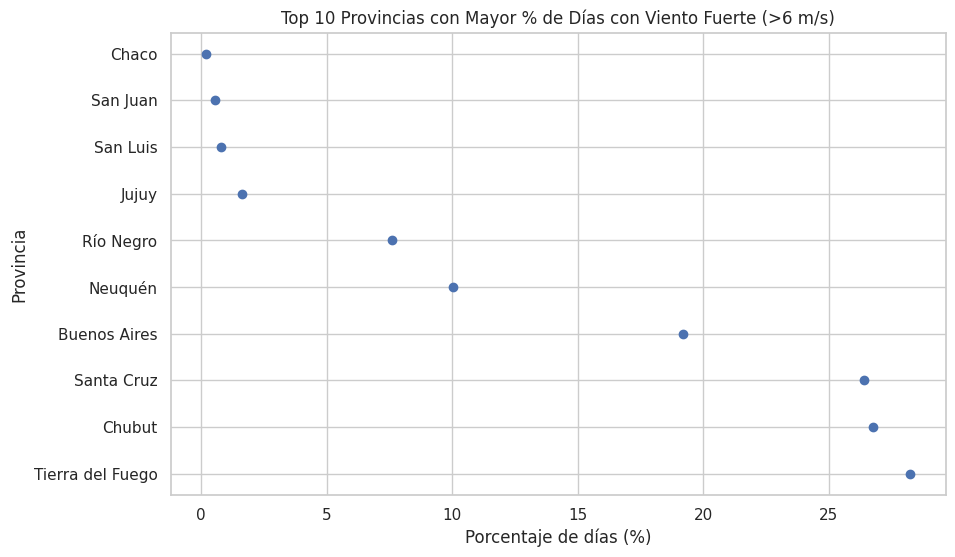

,viento_fuerte
provincia,
Tierra del Fuego,28.26
Chubut,26.75
Santa Cruz,26.40
Buenos Aires,19.19
Neuquén,10.02
Río Negro,7.61
Jujuy,1.64
San Luis,0.79
San Juan,0.58


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Definir umbral de viento fuerte
umbral_viento = 6  # m/s

# 2️⃣ Crear columna booleana
df_clima_crudo["viento_fuerte"] = df_clima_crudo["WS2M"] > umbral_viento

# 3️⃣ Calcular porcentaje de días con viento fuerte por provincia
viento_fuerte_por_prov = (
    df_clima_crudo
    .groupby("provincia")["viento_fuerte"]
    .mean() * 100
).sort_values(ascending=False)

# 4️⃣ Mostrar Top 10
top_10_viento = viento_fuerte_por_prov.head(10)

# 5️⃣ Gráfico tipo dot plot (más profesional que barras)
plt.figure(figsize=(10,6))
plt.scatter(top_10_viento.values, top_10_viento.index)

plt.title("Top 10 Provincias con Mayor % de Días con Viento Fuerte (>6 m/s)")
plt.xlabel("Porcentaje de días (%)")
plt.ylabel("Provincia")

plt.show()

# 6️⃣ Mostrar valores numéricos
display(top_10_viento.round(2))


### 🔹 Conclusión

Los resultados muestran que **Tierra del Fuego, Chubut y Santa Cruz** lideran el ranking de días con viento fuerte, con valores superiores al 25%.

Esto indica que en estas provincias:

- Más de 1 de cada 4 días presenta viento intenso.
- El ambiente favorece mayor pérdida de humedad.
- El manejo agrícola debe considerar protección contra viento y planificación de riego.

En contraste, provincias del norte presentan porcentajes significativamente menores.

Este análisis complementa los estudios de lluvia y evaporación, mostrando que no solo importa cuánto llueve, sino también qué condiciones ambientales pueden acelerar la pérdida de agua.

---

## 3.9 Visualización Dinámica: Mapa Interactivo de Variables Climáticas por Provincia

### 🔹 Introducción

Hasta este punto, los análisis se basaron en gráficos estáticos (barras, dispersión e histogramas) que permiten comparar provincias de forma puntual.  
Para esta ocasión, incorporamos una visualización **más dinámica e interactiva** mediante un **mapa de Argentina con capas**, lo que facilita explorar el comportamiento climático por región y comparar variables directamente sobre el territorio.

El mapa resume promedios provinciales del período 2014–2023 e integra cuatro variables clave:

- 🌧️ **Lluvia promedio** (mm/día)  
- 🌡️ **Temperatura media** (°C)  
- 💨 **Viento medio** (km/h)  
- 💧 **Humedad promedio** (%)  

El usuario puede activar/desactivar capas para analizar patrones espaciales y, al hacer clic en cada provincia, visualizar un resumen multivariable en un popup.

In [ ]:
import folium
print ("Instalado ")

Instalado 


In [ ]:
# ============================================================
# MAPA ARGENTINA — Promedios por Provincia
# Variables: Lluvia (mm/día) + Temp (°C) + Viento (km/h) + Humedad (%)
# Requiere: df_clima_crudo con columnas:
#   provincia, PRECTOTCORR, T2M, WS2M, RH2M
# ============================================================

import folium

# -----------------------------
# 1) Agregación por provincia
# -----------------------------
df_prov = (
    df_clima_crudo
    .groupby("provincia", as_index=False)
    .agg(
        lluvia_media=("PRECTOTCORR", "mean"),
        temp_media=("T2M", "mean"),
        viento_ms=("WS2M", "mean"),
        humedad_media=("RH2M", "mean")
    )
)

# Convertir viento de m/s a km/h (como venías trabajando)
df_prov["viento_kmh"] = df_prov["viento_ms"] * 3.6

# -----------------------------
# 2) Coordenadas (centros aproximados por provincia)
# -----------------------------
coordenadas = {
    "Buenos Aires": (-34.61, -58.38),
    "Córdoba": (-31.42, -64.18),
    "Santa Fe": (-31.63, -60.70),
    "Mendoza": (-32.89, -68.84),
    "Tucumán": (-26.83, -65.22),
    "Salta": (-24.78, -65.41),
    "Misiones": (-27.37, -55.90),
    "Chaco": (-27.45, -58.98),
    "Corrientes": (-27.47, -58.83),
    "Formosa": (-26.18, -58.17),
    "Entre Ríos": (-31.73, -60.53),
    "San Juan": (-31.53, -68.52),
    "San Luis": (-33.30, -66.33),
    "La Pampa": (-36.62, -64.29),
    "Río Negro": (-40.81, -63.00),
    "Neuquén": (-38.95, -68.06),
    "Chubut": (-43.30, -65.10),
    "Santa Cruz": (-51.62, -69.22),
    "Tierra del Fuego": (-54.80, -68.30),
    "La Rioja": (-29.41, -66.86),
    "Catamarca": (-28.47, -65.78),
    "Santiago del Estero": (-27.80, -64.26),
    "Jujuy": (-24.19, -65.30),
}

df_prov["lat"] = df_prov["provincia"].map(lambda x: coordenadas.get(x, (None, None))[0])
df_prov["lon"] = df_prov["provincia"].map(lambda x: coordenadas.get(x, (None, None))[1])

faltantes = df_prov[df_prov[["lat", "lon"]].isna().any(axis=1)]["provincia"].unique()
if len(faltantes) > 0:
    print("⚠️ Provincias sin coordenadas (revisar nombres):", list(faltantes))

df_prov = df_prov.dropna(subset=["lat", "lon"]).copy()

# -----------------------------
# 3) Mapa base + capas (FeatureGroup)
# -----------------------------
m = folium.Map(location=[-38.41, -63.61], zoom_start=4, tiles="cartodbpositron")

capa_lluvia = folium.FeatureGroup(name="🌧️ Lluvia promedio (mm/día)", show=True)
capa_temp   = folium.FeatureGroup(name="🌡️ Temperatura media (°C)", show=False)
capa_viento = folium.FeatureGroup(name="💨 Viento medio (km/h)", show=False)
capa_hum    = folium.FeatureGroup(name="💧 Humedad promedio (%)", show=False)

# Normalización simple para tamaños (radio) sin librerías extra
def scale_radius(series, rmin=6, rmax=18):
    smin, smax = float(series.min()), float(series.max())
    if smax == smin:
        return [ (rmin + rmax) / 2 ] * len(series)
    return list(rmin + (series - smin) * (rmax - rmin) / (smax - smin))

df_prov["r_lluvia"] = scale_radius(df_prov["lluvia_media"])
df_prov["r_temp"]   = scale_radius(df_prov["temp_media"])
df_prov["r_viento"] = scale_radius(df_prov["viento_kmh"])
df_prov["r_hum"]    = scale_radius(df_prov["humedad_media"])

# -----------------------------
# 4) Marcadores por capa + popup multivariable
# -----------------------------
for _, row in df_prov.iterrows():
    popup_html = f"""
    <b>{row['provincia']}</b><br>
    🌧️ Lluvia: {row['lluvia_media']:.2f} mm/día<br>
    🌡️ Temp: {row['temp_media']:.2f} °C<br>
    💨 Viento: {row['viento_kmh']:.2f} km/h<br>
    💧 Humedad: {row['humedad_media']:.2f} %
    """

    # Lluvia
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=row["r_lluvia"],
        color="blue",
        fill=True,
        fill_opacity=0.55,
        popup=folium.Popup(popup_html, max_width=260),
        tooltip=f"{row['provincia']} — {row['lluvia_media']:.2f} mm/día"
    ).add_to(capa_lluvia)

    # Temperatura
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=row["r_temp"],
        color="red",
        fill=True,
        fill_opacity=0.55,
        popup=folium.Popup(popup_html, max_width=260),
        tooltip=f"{row['provincia']} — {row['temp_media']:.2f} °C"
    ).add_to(capa_temp)

    # Viento
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=row["r_viento"],
        color="purple",
        fill=True,
        fill_opacity=0.55,
        popup=folium.Popup(popup_html, max_width=260),
        tooltip=f"{row['provincia']} — {row['viento_kmh']:.2f} km/h"
    ).add_to(capa_viento)

    # Humedad
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=row["r_hum"],
        color="green",
        fill=True,
        fill_opacity=0.55,
        popup=folium.Popup(popup_html, max_width=260),
        tooltip=f"{row['provincia']} — {row['humedad_media']:.2f} %"
    ).add_to(capa_hum)

# Agregar capas y control
capa_lluvia.add_to(m)
capa_temp.add_to(m)
capa_viento.add_to(m)
capa_hum.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# Mostrar mapa
m


### 🔹 Conclusión y Observación de los Datos

El mapa interactivo permite observar con mayor claridad la distribución espacial de las variables climáticas, facilitando comparaciones directas entre regiones.

Se destacan patrones regionales consistentes con los análisis previos:

- El **NEA** tiende a concentrar mayores valores de **lluvia y humedad**, lo que sugiere alta disponibilidad hídrica.
- Regiones **áridas/semiáridas** del oeste y centro muestran condiciones más propensas a pérdida de agua por combinación de **temperatura y viento**.
- Las provincias del sur presentan con frecuencia **vientos más intensos**, lo que puede aumentar el riesgo evaporativo incluso con temperaturas bajas.

Este tipo de visualización complementa los gráficos tradicionales al incorporar el componente geográfico, ofreciendo una herramienta más intuitiva para análisis climático y toma de decisiones en contextos agrícolas.

---

In [ ]:
import plotly.express as px

In [ ]:
import plotly.express as px
import pandas as pd

# Asegurarnos de tener el resumen por provincia
df_clima_prov = df_clima_crudo.groupby("provincia").agg(
    lluvia_media=("PRECTOTCORR", "mean"),
    temp_media=("T2M", "mean"),
    viento_medio=("WS2M", "mean"),
    humedad_media=("RH2M", "mean")
).reset_index()

# Crear gráfico multivariable
fig = px.scatter(
    df_clima_prov,
    x="temp_media",
    y="lluvia_media",
    size="viento_medio",
    color="humedad_media",
    hover_name="provincia",
    title="Análisis Multivariable Climático por Provincia (2014–2023)",
    labels={
        "temp_media": "Temperatura Media (°C)",
        "lluvia_media": "Lluvia Media (mm/día)",
        "viento_medio": "Viento Medio (km/h)",
        "humedad_media": "Humedad Media (%)"
    },
    size_max=40,
    color_continuous_scale="Turbo"
)

fig.show()


=== Matriz de correlación (promedios por provincia) ===


,temp_media,lluvia_media,viento_media,humedad_media
temp_media,1.000000,0.525157,-0.528172,-0.107340
lluvia_media,0.525157,1.000000,-0.394522,0.625215
viento_media,-0.528172,-0.394522,1.000000,0.197354
humedad_media,-0.107340,0.625215,0.197354,1.000000


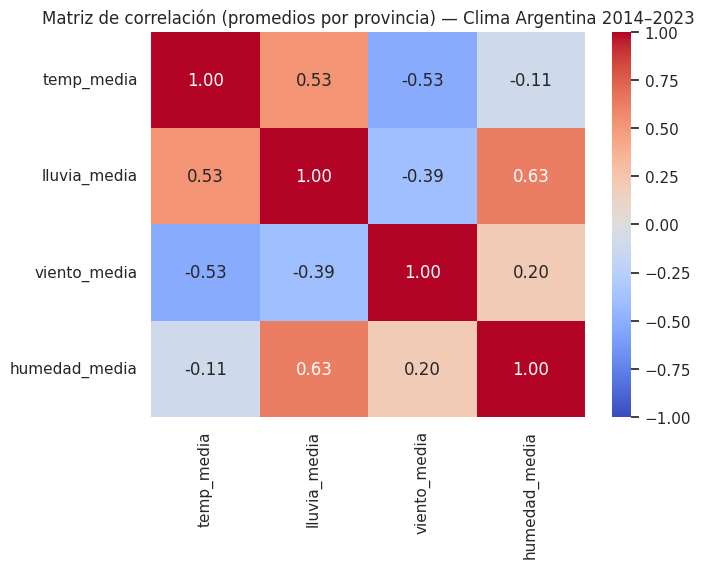

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Resumen por provincia
df_prov = (
    df_clima_crudo.groupby("provincia", as_index=False)
    .agg(
        temp_media=("T2M", "mean"),
        lluvia_media=("PRECTOTCORR", "mean"),
        viento_media=("WS2M", "mean"),
        humedad_media=("RH2M", "mean")
    )
)

df_corr_prov = df_prov[["temp_media", "lluvia_media", "viento_media", "humedad_media"]]

corr_prov = df_corr_prov.corr(method="pearson")

print("=== Matriz de correlación (promedios por provincia) ===")
display(corr_prov)

plt.figure(figsize=(7,5))
sns.heatmap(corr_prov, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de correlación (promedios por provincia) — Clima Argentina 2014–2023")
plt.show()
